# A simple state-and-transition model of urban development

In [26]:
%matplotlib inline

# Import important libraries
import numpy as np
import matplotlib.pyplot as plt
import math as m

import warnings
warnings.filterwarnings('ignore')

In [31]:
Ntime = 100 # Number of time steps to run (years)
Ring = 6 # Number of rings of cells to evaluate neighborhood

# Set Transition probabilities
P_WU_lonely  = 0.00
P_WU_crowded = 0.035
f_UrbanCrit  = 0.22
k_logistic   = 10.0

In [32]:
# Let's assume once a wild pixel is converted to urban, there's no going back. Thus, 
# the transition probability of urban to wild (P_UW) is zero

# Load the initial city map
CityMap = np.load('InitialCity.npy')
CityMapInit = np.copy(CityMap) #Clone the initial condition. We'll be over-writing CityMap

dims = np.shape(CityMap)
Nrows = dims[0]
Ncols = dims[1]

for i in xrange(0,Ntime):
    
    CityMapUpdated = np.copy(CityMap)    
    
    for j in xrange(0,Nrows):
        
        for k in xrange(0,Ncols):
            
            if(CityMap[j,k] == 0.0): # Only need to consider wild pixels
                
                # Get the starting and ending row and column numbers N=Ring pixels 
                # in the each direction of the pixel in question (the neighborhood)
                StartRow = np.max((j-Ring-1,0))
                EndRow   = np.min((j+Ring+1,Nrows-1))
                StartCol = np.max((k-Ring-1,0))
                EndCol   = np.min((k+Ring+1,Ncols-1))
                
                # Get the 1s and 0s of the surrounding neighborhood
                HoodMap = CityMap[StartRow:EndRow,StartCol:EndCol]

                # Get the fraction of urbanized pixels in the neighborhood
                dimsHoodMap = np.shape(HoodMap)
                NHoodPix = float(dimsHoodMap[0]*dimsHoodMap[1])
                NHoodUrb = np.sum(HoodMap)
                
                f_Urban = NHoodUrb/NHoodPix
                
                # Get the urbanization weighted transition probability
                # Transform neighborhood fraction to 
                g_Urban = np.tan((f_Urban - 0.5)*m.pi)
                g_UrbanCrit = np.tan((f_UrbanCrit - 0.5)*m.pi)
                
                P_WU = P_WU_crowded / (1 + np.exp(-k_logistic*(float(g_Urban - g_UrbanCrit)))) + P_WU_lonely
                
                if(np.random.uniform() < P_WU): # Transition if true
                    CityMapUpdated[j,k] = 1.0 # Now urbanized
                    
    print "Completed time step " + format(i) + ". " + format(float(i+1)/float(Ntime)*100.0) + "% complete"
    CityMap = np.copy(CityMapUpdated)


Completed time step 0. 1.0% complete
Completed time step 1. 2.0% complete
Completed time step 2. 3.0% complete
Completed time step 3. 4.0% complete
Completed time step 4. 5.0% complete
Completed time step 5. 6.0% complete
Completed time step 6. 7.0% complete
Completed time step 7. 8.0% complete
Completed time step 8. 9.0% complete
Completed time step 9. 10.0% complete
Completed time step 10. 11.0% complete
Completed time step 11. 12.0% complete
Completed time step 12. 13.0% complete
Completed time step 13. 14.0% complete
Completed time step 14. 15.0% complete
Completed time step 15. 16.0% complete
Completed time step 16. 17.0% complete
Completed time step 17. 18.0% complete
Completed time step 18. 19.0% complete
Completed time step 19. 20.0% complete
Completed time step 20. 21.0% complete
Completed time step 21. 22.0% complete
Completed time step 22. 23.0% complete
Completed time step 23. 24.0% complete
Completed time step 24. 25.0% complete
Completed time step 25. 26.0% complete
Compl

(-0.5, 285.5, 298.5, -0.5)

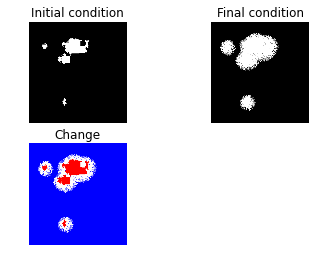

In [33]:
# Make some plots
plt.figure(1)
plt.subplot(221)
plt.imshow(CityMapInit,cmap='gray')
plt.title("Initial condition")
plt.axis('off')

plt.subplot(222)
plt.imshow(CityMap,cmap='gray')
plt.title("Final condition")
plt.axis('off')

plt.subplot(223)
plt.imshow(CityMap+CityMapInit,cmap='bwr')
plt.title("Change")
plt.axis('off')
